In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure/heart_failure.csv


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [3]:
df= pd.read_csv('/kaggle/input/heart-failure/heart_failure.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


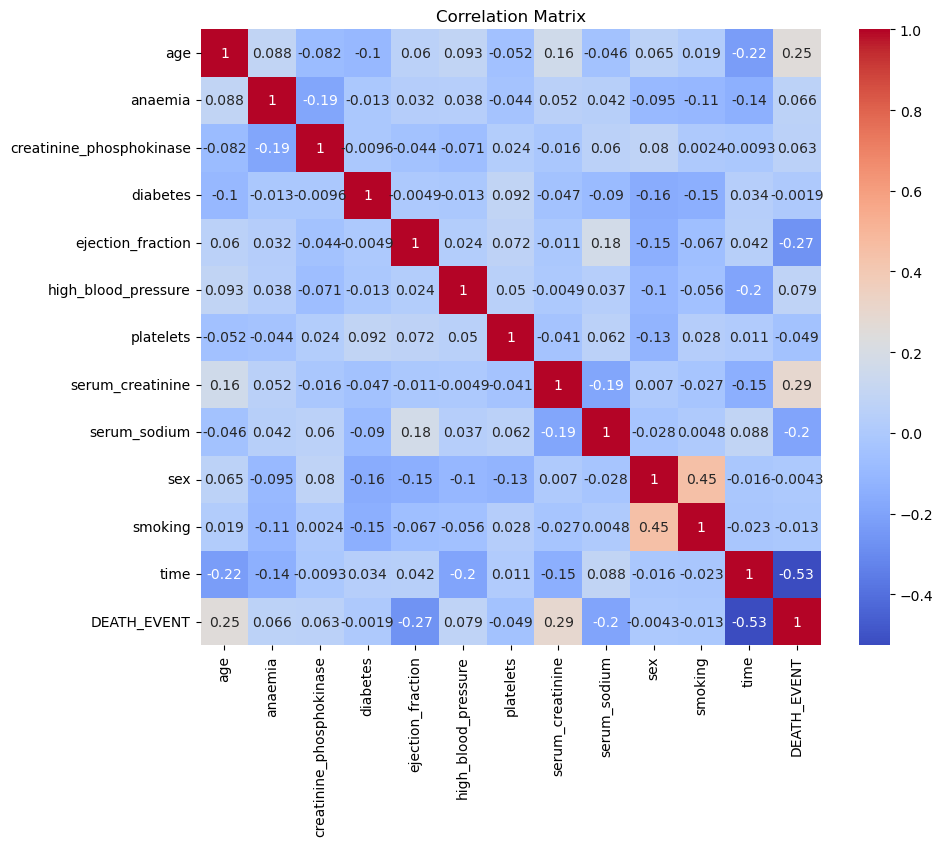

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

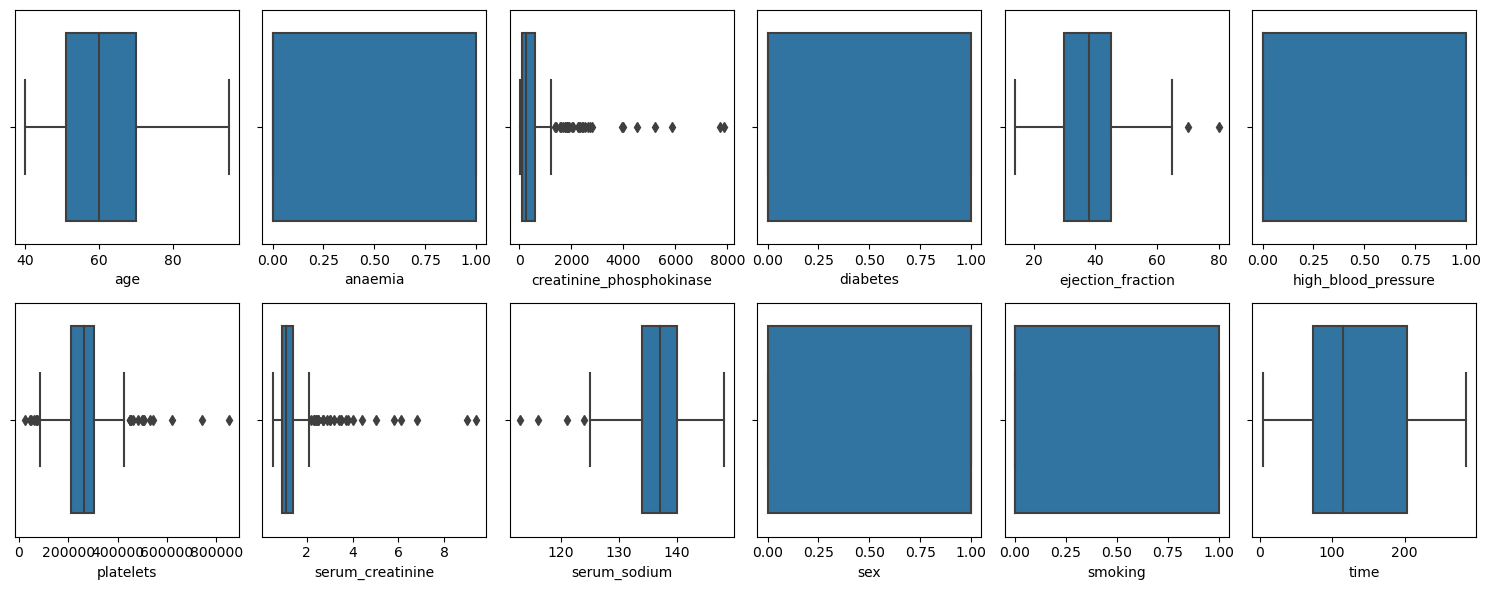

In [6]:
def boxplots(df):
    cols = df.columns[:-1]
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    for idx, col in enumerate(cols):
        i = idx // m
        j = idx % m
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, ax=axes[i][j])
        else:
            sns.boxplot(data=df, x=col, ax=axes[i][j])
    plt.tight_layout()
    plt.show()

boxplots(df)

In [7]:
def outliers_removal(df, col):
    if df[col].dtype != 'object':
        perc = np.percentile(df[col], [0, 25, 50, 75, 100])
        iqr = perc[3] - perc[1]
        _min = perc[1] - 1.5*iqr
        _max = perc[3] + 1.5*iqr
        df.loc[df[col] > _max, col] = _max
        df.loc[df[col] < _min, col] = _min
    return df

for col in df.columns[:-1]:
    df = outliers_removal(df, col)

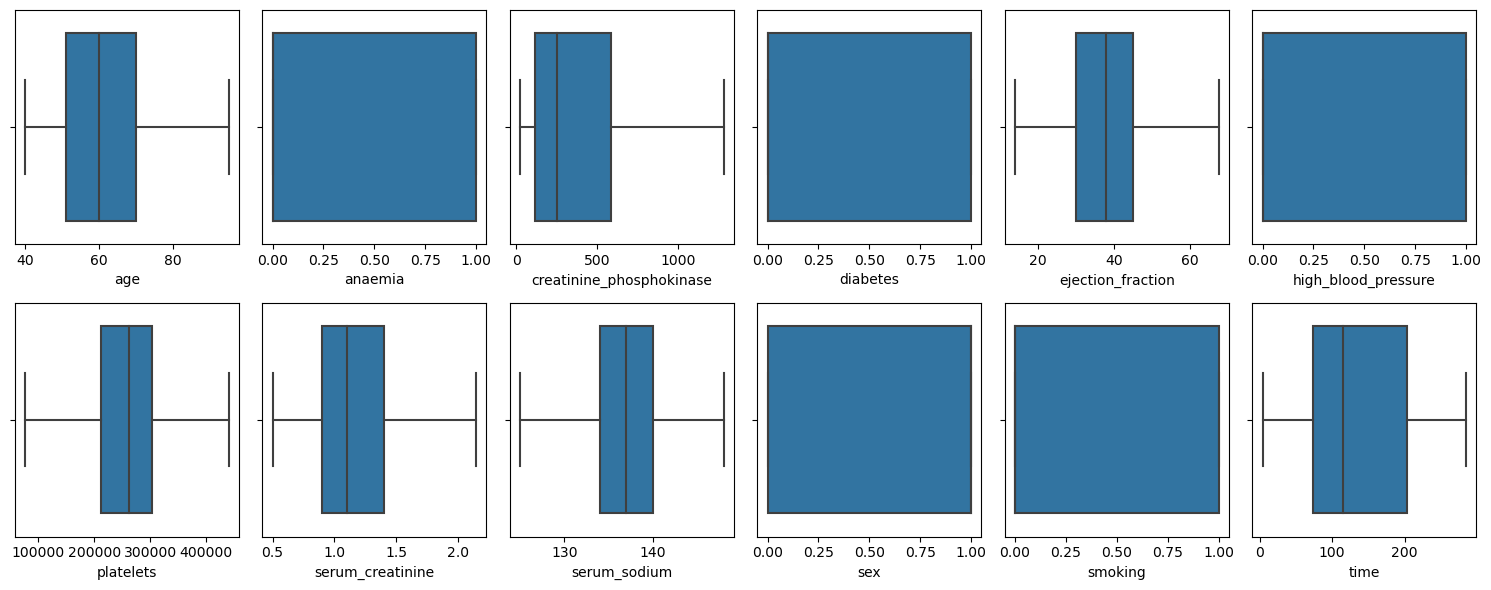

In [8]:
boxplots(df)

In [9]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

Accuracy: 0.7333333333333333
Confusion Matrix:
[[31  4]
 [12 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.89      0.79        35
           1       0.76      0.52      0.62        25

    accuracy                           0.73        60
   macro avg       0.74      0.70      0.71        60
weighted avg       0.74      0.73      0.72        60



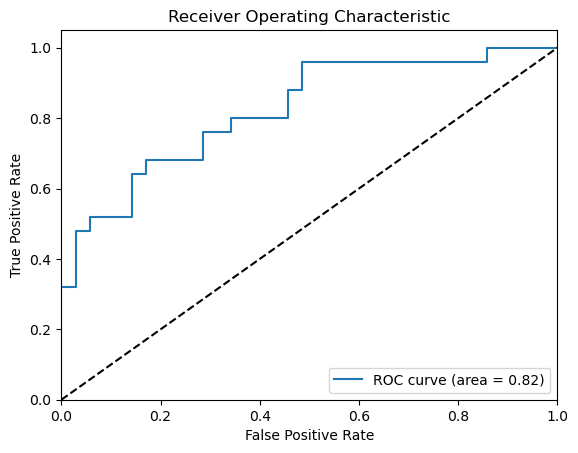

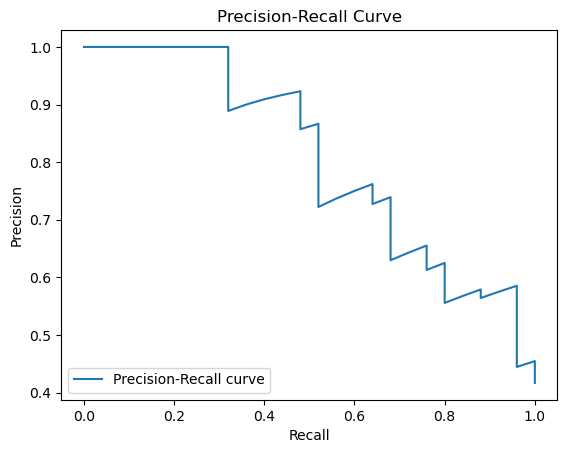

Cross-Validation Scores: [0.68333333 0.76666667 0.85       0.91666667 0.6779661 ]
Average Cross-Validation Score: 0.7789265536723164


In [10]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=2000) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

probas = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, probas[:, 1])

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print('Cross-Validation Scores:', cv_scores)
print('Average Cross-Validation Score:', np.mean(cv_scores))

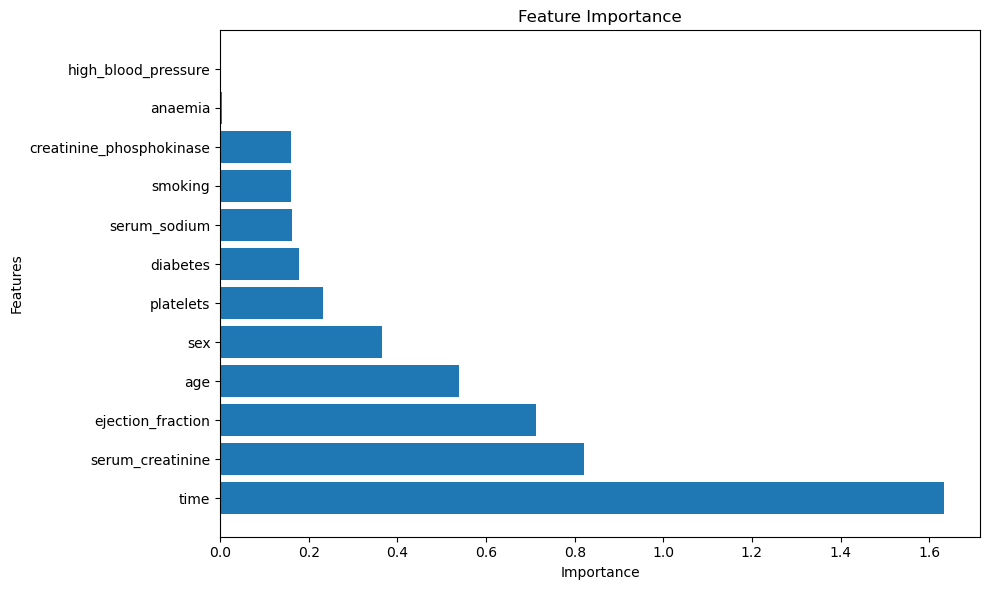

In [11]:
feature_importance = np.abs(model.coef_[0])
feature_names = df.drop('DEATH_EVENT', axis=1).columns
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(feature_importance)), sorted_feature_names)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()